## Feature selection of pyradiomic feutures
 #### As refered in article 2 the most common algoritms for feuture selection are random forest, PCA(principle component analysis) and LASSO(least absolute shrinkage and selection operator) we'll be using all 3 and choosing the one that has the best results in several metrics

library imports + dataset handling comemt further

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
dataset_path = 'radiomic_features_pylidc_and_fourier.csv'  # Replace with the actual path to your CSV file
data = pd.read_csv(dataset_path)
# Get the shape of the dataset (rows, columns)
print(data.shape)

# Get basic statistics about the dataset
print(data.describe())
X = data.drop(columns=['malignancy_mode','malignancy_mean'])  # Replace 'target' with the actual column name of your labels
y = data['malignancy_mode']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


(2651, 126)
       diagnostics_Image-original_Mean  diagnostics_Image-original_Minimum  \
count                      2651.000000                         2651.000000   
mean                        -36.901213                        -2031.011316   
std                          35.392737                          837.572472   
min                        -273.544294                        -3024.000000   
25%                         -44.281785                        -3024.000000   
50%                         -26.226244                        -2048.000000   
75%                         -14.955267                        -1024.000000   
max                          -0.606900                         -220.000000   

       diagnostics_Image-original_Maximum  diagnostics_Mask-original_VoxelNum  \
count                         2651.000000                         2651.000000   
mean                             0.506601                          767.754055   
std                              9.546720 

## 0 Data preparation

Due to the imbalence of the malign and benign class, as recomended by the professor we decided to apply some tecnics to balance the classes.
In the provided documents we dind't find references to either undersampling or oversampling so we went to https://imbalanced-learn.org/ to learn more about the different tecnics and we saw that common oversampling tecnics are SMOTE that generates new samples by interpolating existing ones and ADASYN that generates samples like smote but focuses more on missclassified minority class samples. We decided to use both to see the diference betwin the two tecnics, about oversampling we decided not to use it due to the fact that we would be deliting half the samples of the bennign class and there are hybrid models like SMOTEENN and SMOTETomek that combine both undersampling and oversampling so we decided to use SMOTETomek since betwin the 2 is the least agressive in terms of removing samples while still cleaning the daatset of noisy data and compared to undersampling tecnics it reduces less samples

#### 0.1 SMOTE

#### 0.2 ADASYN

#### 0.3 SMOTETomek

## 1 Feature selection

##### 1.1 Random forest

In [8]:
# Initialize and train the Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

rf.fit(X_train, y_train)

# Make predictions and calculate accuracy before feature selection
y_pred = rf.predict(X_test)
initial_accuracy = accuracy_score(y_test, y_pred)
print(initial_accuracy)


0.5480225988700564


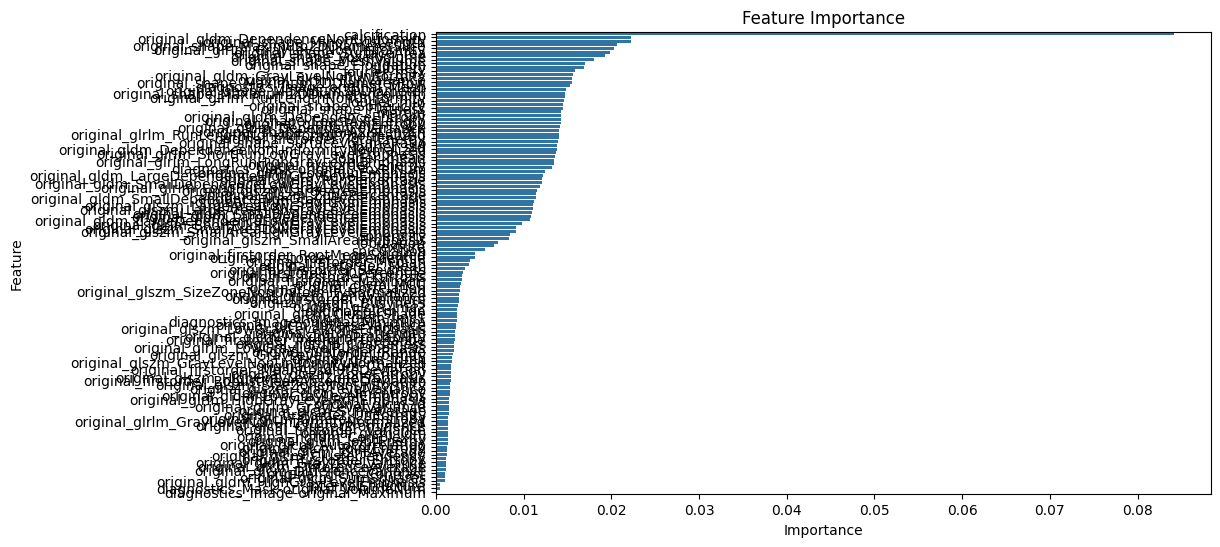

In [4]:
# Get feature importances
feature_importances = rf.feature_importances_

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_df = feature_importance_df

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.show()


In [5]:
# Select top 5 features (as an example)
top_features = feature_importance_df.head(10)['Feature'].values

# Create a new dataset with only the top features
X_train_selected = X_train[top_features]
X_test_selected = X_test[top_features]


# Train the classifier with selected features
rf_selected = RandomForestClassifier(n_estimators=100, random_state=42)
rf_selected.fit(X_train_selected, y_train)

# Make predictions and calculate accuracy after feature selection
y_pred_selected = rf_selected.predict(X_test_selected)
selected_accuracy = accuracy_score(y_test, y_pred_selected)

print(f'Accuracy before feature selection: {initial_accuracy:.4f}')
print(f'Accuracy after feature selection: {selected_accuracy:.4f}')


Accuracy before feature selection: 0.5556
Accuracy after feature selection: 0.5330


#### 1.2 LASSO

In [6]:
# Convert the continuous target into binary labels (benign/malignant)
threshold = 0.5  # Assuming values >= 0.5 are malignant
y_binary = np.where(y >= threshold, 1, 0)  # 1 for malignant, 0 for benign

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)


# Standardize the features (important for LASSO)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a Logistic Regression model with L1 (LASSO) regularization
lasso = LogisticRegression(penalty='l1', solver='liblinear', C=1.0, max_iter=1000)
lasso.fit(X_train_scaled, y_train)

# Get the coefficients
coefficients = lasso.coef_

# Find the indices of the non-zero coefficients
non_zero_features = np.where(coefficients != 0)[1]
non_zero_features = np.unique(non_zero_features)
# Print the selected features
print("Selected features:", non_zero_features)

# You can map back these indices to the original feature names if needed
selected_feature_names = X.columns[non_zero_features]
print("Selected feature names:", selected_feature_names)

Selected features: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  21  23  24  25  26  27  28  29  30  31  32  33  34  38  40  41
  42  45  48  50  51  52  53  56  57  58  61  62  63  64  65  68  70  71
  72  74  75  76  79  80  81  82  83  84  85  86  87  88  90  91  92  93
  95  96  97  98  99 100 101 102 103 105 106 107 109 110 111 112 113 114
 115 116 117 118 119 120 121 122]
Selected feature names: Index(['diagnostics_Image-original_Mean', 'diagnostics_Image-original_Minimum',
       'diagnostics_Image-original_Maximum',
       'diagnostics_Mask-original_VoxelNum',
       'diagnostics_Mask-original_VolumeNum', 'original_shape_Elongation',
       'original_shape_Flatness', 'original_shape_LeastAxisLength',
       'original_shape_MajorAxisLength',
       'original_shape_Maximum2DDiameterColumn',
       'original_shape_Maximum2DDiameterRow',
       'original_shape_Maximum2DDiameterSlice',
       'original_shape_Maximum3DDiameter', 'original_shape_Me

#### 1.3 PCA

In [9]:
# Step 1: Standardize the data
scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
X_scaled = scaler.fit_transform(X)

# Step 2: Apply PCA
pca = PCA(n_components=X.shape[1])  # Fit PCA to all features
X_pca = pca.fit_transform(X_scaled)

# Step 3: Create a DataFrame with feature importance
pca_df = pd.DataFrame(pca.components_, columns=X.columns)

# Step 4: Calculate the absolute value of the feature weights
feature_importance = np.abs(pca_df).sum(axis=0)

# Step 5: Create a DataFrame to see feature importance
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importance
})

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Step 6: Print the feature importance
print("Feature Importance:")
print(feature_importance_df)

# Optional: Select top N features
N = 10  # Change this to the number of top features you want
top_features = feature_importance_df.head(N)
print(f"\nTop {N} features based on PCA:")
print(top_features)

Feature Importance:
                                                                                 Feature  \
original_glcm_DifferenceVariance                        original_glcm_DifferenceVariance   
original_glcm_Correlation                                      original_glcm_Correlation   
original_glcm_Contrast                                            original_glcm_Contrast   
original_glcm_Idmn                                                    original_glcm_Idmn   
original_glrlm_ShortRunLowGrayLevelEmphasis  original_glrlm_ShortRunLowGrayLevelEmphasis   
...                                                                                  ...   
lobulation                                                                    lobulation   
sphericity                                                                    sphericity   
calcification                                                              calcification   
fourier_min                                                 

## 2 Classifiction models

#### 2.1 Logistic regression

#### 2.2 Random forest

#### 2.3 Svm

## 3 Performance comparation